
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

<font size=5 color=cyan> Names: sobhan zamani - ryan hadidi

Student Numbers:  </font> 402111574 - 402111164

In [ ]:
!pip install -q pybullet Box2D
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 14.6 MB/s eta 0:00:00
Fri Sep  5 18:24:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W

Import necessary packages.

In [ ]:
pip install "numpy<2" "gym==0.26.*"


In [ ]:
%pip uninstall -y gym
%pip install -U gymnasium shimmy pybullet-envs-gymnasium pybullet


Found existing installation: gym 0.26.2
Uninstalling gym-0.26.2:
  Successfully uninstalled gym-0.26.2


In [1]:
# import os
# import numpy as np
# import torch as T
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from torch.distributions import Normal

# import warnings
# warnings.filterwarnings('ignore')
# from gym.wrappers import RecordVideo
# import gym
# import pybullet_envs
# np.bool8 = np.bool_
# from tqdm.notebook import trange
# from IPython.display import Video
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')

import gymnasium as gym
from gymnasium.wrappers import RecordVideo

if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

from tqdm.notebook import trange
from IPython.display import Video


In [64]:
SEED = 0
env = gym.make("HalfCheetahBulletEnv-v0", render_mode="rgb_array")
obs, info = env.reset(seed=SEED)
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
done = terminated or truncated
env.close()


In [65]:
env = gym.make("HalfCheetahBulletEnv-v0", render_mode="rgb_array")
env = RecordVideo(env, video_folder="tmp/videos", episode_trigger=lambda ep: True)


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [2]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [3]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        self.state_memory = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.next_state_memory = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.action_memory = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.reward_memory = np.zeros((buffer_size,1), dtype=np.float32)
        self.done_memory = np.zeros((buffer_size,1), dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        idx = self.ptr
        self.state_memory[idx] = state
        self.action_memory[idx] = action
        self.reward_memory[idx] = reward
        self.next_state_memory[idx] = state_
        self.done_memory[idx] = done

        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0:
            self.is_full = True

    def load_batch(self, batch_size):
        idx = np.random.choice(self.ptr, batch_size, replace=False)

        states  = self.state_memory[idx]
        actions = self.action_memory[idx]
        rewards = self.reward_memory[idx]
        states_ = self.next_state_memory[idx]
        done    = self.done_memory[idx]

        return states, actions, rewards, states_, done


## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [4]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        os.makedirs(ckpt_dir, exist_ok=True)
        self.ckpt_path = os.path.join(ckpt_dir, f'{name}_sac.pth')

        self.fc1 = nn.Linear(self.state_dims + self.action_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        self.device = T.device('cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.to(self.device)

    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.max_action = max_action
        os.makedirs(ckpt_dir, exist_ok=True)
        self.ckpt_path = os.path.join(ckpt_dir, f'{name}_sac.pth')

        self.fc1 = nn.Linear(self.state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)

        self.mu = nn.Linear(fc2_dims, self.action_dims)
        self.log_std = nn.Linear(fc2_dims, self.action_dims)

        self.device = T.device('cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std(x).clamp(min=-20.0, max=2.0)
        sigma = log_std.exp()
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)

        dist = T.distributions.Normal(mu, sigma)
        if reparameterize:
            z = dist.rsample()
        else:
            z = dist.sample()

        action = T.tanh(z) * T.tensor(self.max_action).to(self.device)
        log_probs = dist.log_prob(z) - T.log(1 - action.pow(2) + 1e-6)
        log_probs = log_probs.sum(dim=1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        os.makedirs(ckpt_dir, exist_ok=True)
        self.ckpt_path = os.path.join(ckpt_dir, f'{name}_sac.pth')

        self.fc1 = nn.Linear(self.state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [5]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        
        self.gamma = gamma
        self.alpha_lr = alpha
        self.beta_lr = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup or 0
        self.reparam_noise_lim = float(reparam_noise_lim or 0.0)
        self.name = name
        self.device = T.device('cpu')

        os.makedirs(ckpt_dir, exist_ok=True)
        self.ckpt_dir = ckpt_dir

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.step_count = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)
        os.makedirs(self.full_path, exist_ok=True)

        self.memory = ReplayBuffer(memory_size, 
                                   self.state_dims, 
                                   self.action_dims)

        self.actor = Actor(alpha=self.alpha_lr,
                           state_dims=self.state_dims,
                           action_dims=self.action_dims,
                           fc1_dims=self.fc1_dim,
                           fc2_dims=self.fc2_dim,
                           max_action=self.max_action,
                           reparam_noise=self.reparam_noise_lim,
                           name='Actor', ckpt_dir=self.full_path)

        self.critic_1 = Critic(beta=self.beta_lr,
                               state_dims=self.state_dims,
                               action_dims=self.action_dims,
                               fc1_dims=self.fc1_dim,
                               fc2_dims=self.fc2_dim,
                               name='Critic1', ckpt_dir=self.full_path)

        self.critic_2 = Critic(beta=self.beta_lr,
                               state_dims=self.state_dims,
                               action_dims=self.action_dims,
                               fc1_dims=self.fc1_dim,
                               fc2_dims=self.fc2_dim,
                               name='Critic2', ckpt_dir=self.full_path)

        self.value = Value(beta=self.beta_lr,
                           state_dims=self.state_dims,
                           fc1_dims=self.fc1_dim,
                           fc2_dims=self.fc2_dim,
                           name='Value', ckpt_dir=self.full_path)

        self.target_value = Value(beta=self.beta_lr,
                                  state_dims=self.state_dims,
                                  fc1_dims=self.fc1_dim,
                                  fc2_dims=self.fc2_dim,
                                  name='TargetValue', ckpt_dir=self.full_path)

        self.update_parameters(tau=1.0)

    def choose_action(self, state, deterministic=False, reparameterize=False):
        state = T.tensor(state, dtype=T.float32, device= T.device('cpu'))
        state = state.unsqueeze(0)
        
        self.actor.eval()
        with T.no_grad():
            action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)
            action = action.squeeze(0).cpu().numpy()
            self.actor.train()
            return action
                

    def store_transition(self, state, action, reward, state_, done):
        self.step_count += 1
        self.memory.store_transition(state, action, reward, state_, done)
        

    def load_batch(self):
        states, actions, rewards, states_, dones = self.memory.load_batch(self.batch_size)
        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        dones = T.tensor(dones).to(self.actor.device)
        return states, actions, rewards, states_, dones

    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        new_state_dict = {
            name: tau * param.detach() + (1 - tau) * self.target_value.state_dict()[name].detach()
            for name, param in self.value.named_parameters()
        }

        self.target_value.load_state_dict(new_state_dict)


    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        max_mem = self.memory.buffer_size if self.memory.is_full else self.memory.ptr
        if max_mem < self.batch_size or (self.step_count % self.update_period) != 0 or self.step_count < self.warmup:
            return

        states, actions, rewards, states_, dones = self.load_batch()
        with T.no_grad():
            new_actions, log_probs = self.actor.sample_normal(states, reparameterize=False)
            q1_new = self.critic_1(states, new_actions)
            q2_new = self.critic_2(states, new_actions)
            q_min_new = T.min(q1_new, q2_new)
            v_target = q_min_new - self.alpha_lr * log_probs

        v = self.value(states)
        value_loss = F.mse_loss(v, v_target)
        self.value.optimizer.zero_grad(set_to_none=True)
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_new = self.critic_1(states, new_actions)
        q2_new = self.critic_2(states, new_actions)
        q_min_new = T.min(q1_new, q2_new)
        actor_loss = T.mean(self.alpha_lr * log_probs - q_min_new)
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        with T.no_grad():
            v_next = self.target_value(states_)
            v_next[dones] = 0.0
            q_hat = self.reward_scale * rewards + self.gamma * v_next

        q1 = self.critic_1(states, actions)
        q2 = self.critic_2(states, actions)
        critic1_loss = F.mse_loss(q1, q_hat)
        critic2_loss = F.mse_loss(q2, q_hat)

        self.critic_1.optimizer.zero_grad()
        critic1_loss.backward()
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad()
        critic2_loss.backward()
        self.critic_2.optimizer.step()

        self.update_parameters()
            
        self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [6]:
# Configuration parameters
env_name = 'HalfCheetah-v5'
dir = 'tmp'
n_games = 180

gamma = 0.99
alpha = 7e-4
beta = 7e-4
fc1_dim = 256
fc2_dim = 256
memory_size = 10_000_000
batch_size = 256
tau = 0.007
update_period = 2
reward_scale = 2.
warmup = 15_000
reparam_noise_lim = 1e-6
record_video = True


## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

| Game:      0 | Score:    -258.01 | Best score:    -258.01 | Avg score    -258.01 | Learning iter:          0 |
| Game:      1 | Score:    -272.99 | Best score:    -258.01 | Avg score    -265.50 | Learning iter:          0 |
| Game:      2 | Score:    -216.35 | Best score:    -216.35 | Avg score    -249.12 | Learning iter:          0 |
| Game:      3 | Score:    -285.03 | Best score:    -216.35 | Avg score    -258.10 | Learning iter:          0 |
| Game:      4 | Score:    -263.70 | Best score:    -216.35 | Avg score    -259.22 | Learning iter:          0 |
| Game:      5 | Score:    -267.88 | Best score:    -216.35 | Avg score    -260.66 | Learning iter:          0 |
| Game:      6 | Score:    -279.86 | Best score:    -216.35 | Avg score    -263.40 | Learning iter:          0 |
| Game:      7 | Score:    -413.38 | Best score:    -216.35 | Avg score    -282.15 | Learning iter:          0 |
| Game:      8 | Score:    -301.00 | Best score:    -216.35 | Avg score    -284.24 | Learning it

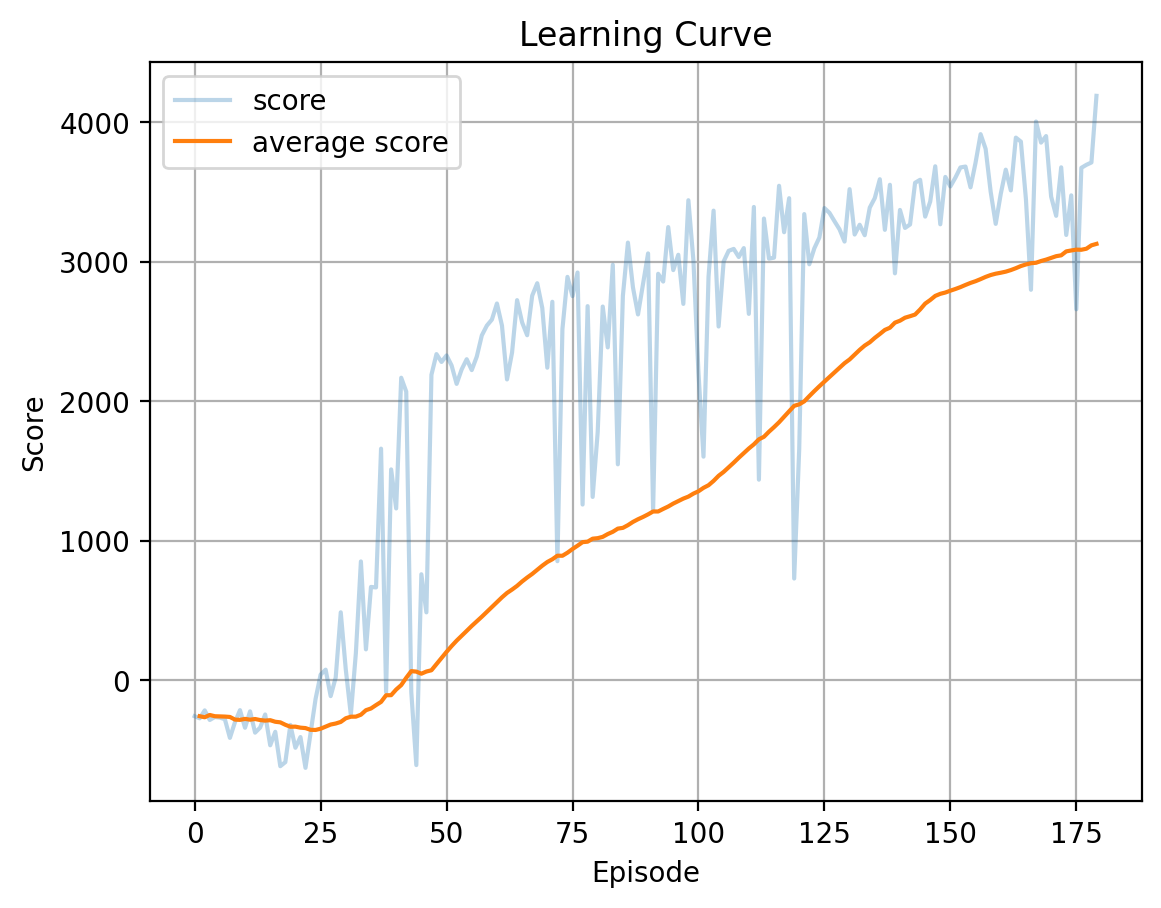

In [7]:
import gymnasium
env = gymnasium.make(env_name, render_mode="rgb_array") 
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    video_dir = os.path.join(dir_path, 'videos')
    os.makedirs(video_dir, exist_ok=True)
    env = RecordVideo(env, video_folder=video_dir,
                      episode_trigger=lambda ep: ep == n_games - 1)

agent = None

if agent is None:
    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_act    = float(env.action_space.high[0])
    agent = Agent(gamma, alpha, beta, state_dim, action_dim, max_act, fc1_dim, fc2_dim,
                  memory_size, batch_size, tau, update_period, reward_scale, warmup,
                  reparam_noise_lim, name='SAC', ckpt_dir=dir_path)

scores = []
best_score = -np.inf

for game in range(n_games):
    state, info = env.reset()
    done = False
    score = 0.0

    while not done:
        action = agent.choose_action(state, deterministic=False, reparameterize=False)
        state_, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.store_transition(state, action, reward, state_, done)
        agent.learn()

        score += reward
        state = state_

    scores.append(score)
    avg_score = np.mean(scores[-100:])
    best_score = max(best_score, score)
    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

    if avg_score > best_score:
        agent.save_model()

agent.save_model()
env.close()
plot_learning_curve(scores, agent.full_path)


## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [ ]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)